<a href="https://colab.research.google.com/github/nonu0/Object-detection/blob/master/computer_vision_Torchvision_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import pandas as pd
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from pathlib import Path
import requests
from timeit import default_timer as timer

#Getting dataset 

In [ ]:
#Setup train data

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [ ]:
image,label = train_data[10]
image,label


In [ ]:

class_names = train_data.classes
class_names

In [ ]:
train_data.class_to_idx

In [ ]:
print(f"image shape:{image.shape}")
print(f"image label:{class_names[label]}")

image shape:torch.Size([1, 28, 28])
image label:T-shirt/top


(-0.5, 27.5, 27.5, -0.5)

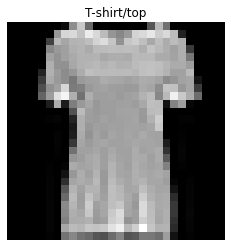

In [ ]:
image.shape
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(10,7))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else  "cpu"
device

'cpu'

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

len(train_dataloader),len(test_dataloader)

(1875, 313)

In [ ]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape

torch.Size([32, 1, 28, 28])

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"image size:{img.shape}")

In [ ]:
flatten_model = nn.Flatten()

In [ ]:
X = train_features_batch[0]
X.shape

torch.Size([1, 28, 28])

In [ ]:
output = flatten_model(X)
output.shape

torch.Size([1, 784])

#Model

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units,),
            nn.Linear(in_features=hidden_units,out_features=output_shape,)
        )

    def forward(self,x):
        return self.layer_stack(x)

model = FashionMNISTModel(input_shape=784,hidden_units=10,output_shape=len(class_names))
model

#Get evaluation metrics

In [ ]:
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time = end-start
    print(f"Train time on device:{device}:{total_time:.2f} secs.")
    return total_time

In [ ]:
start_time = timer()
#code code
end_time = timer()
print_train_time(start=start_time,end=end_time ,device='cpu')

Train time on device:cpu:0.00 secs.


3.568500005712849e-05

In [ ]:
if Path("helper_functions.py").is_file():
    print("file already exists")

else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Downloading...")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

file already exists


In [ ]:
from helper_functions import accuracy_fn,plot_decision_boundary,plot_predictions

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

#Training loop

In [ ]:
from torch.nn.modules import loss
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n...")
    #Training

    train_loss = 0
    #Loop through the batches

    for batch,(X,y) in enumerate(train_dataloader):
        model.train()
        #1.forward 
        y_preds = model(X)

        #2.loss
        loss = loss_fn(y_preds,y)
        train_loss += loss

        #3.optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

        #To get total loss
    train_loss /= len(train_dataloader)


    #Testing
    test_loss,test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_preds = model(X_test)

            test_loss += loss_fn(test_preds,y_test)
            test_acc += accuracy_fn(y_true=y_test,y_pred=test_preds.argmax(dim=1))
            #test loss per batch
            test_loss/=len(test_dataloader)
            # test accuracy per batch
            test_acc /= len(test_dataloader)

        print(f"\nTrain loss:{train_loss} | test loss:{test_loss:.3f} | testt accuracy:{test_acc:.2f}")

train_time_end_on_cpu = timer()
total_train_tim_model = print_train_time(start=train_time_start_on_cpu,
                                         end=train_time_end_on_cpu,
                                         device=str(next(model.parameters()).device))